# Exercise Climate Networks of Indian Monsoon

In this exercise we will explore patterns of rainfall in India during the monsoon season.  
We will proceed similarly as in the tutorial:  
1. Load data and preprocess 
2. Pairwise-Intercomparison between all time series
3. Generate Adjacency
4. Generate Network and analyze it   


In [2]:
# import required packages
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import plot_utils as put
import scipy.stats as st
import networkx as nx  # For network analysis
import networkit as nk  # For community detection
from importlib import reload

## Data loading


In [3]:
# Load the data to an xarray dataset
ds = xr.open_dataset('./data/mswep_pr_1_india_jjas_ds.nc')
# Just executing the dataset will give you a first overview over the dataset
ds

<xarray.Dataset>
Dimensions:  (time: 4880, lat: 30, lon: 30)
Coordinates:
  * time     (time) datetime64[ns] 1980-06-01 1980-06-02 ... 2019-09-30
  * lat      (lat) float64 7.538 8.543 9.548 10.55 ... 33.67 34.67 35.68 36.68
  * lon      (lon) float64 65.66 66.67 67.67 68.67 ... 91.73 92.73 93.73 94.74
Data variables:
    pr       (time, lat, lon) float32 ...

Plot the global mean air temperature nicer using cartopy

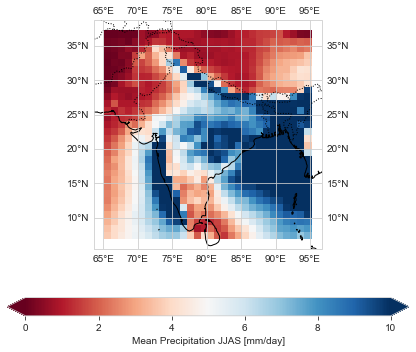

In [5]:
reload(put)
var_name = 'pr'
mean_pr = ds[var_name].mean(dim='time')
im = put.plot_map(mean_pr, label='Mean Precipitation JJAS [mm/day]', 
                  projection='PlateCarree',
                  cmap='RdBu',
                  vmin=0, vmax=10)

## Preprocess Data

### Detrend data and create anomaly time series
Plot the average global mean temperature.

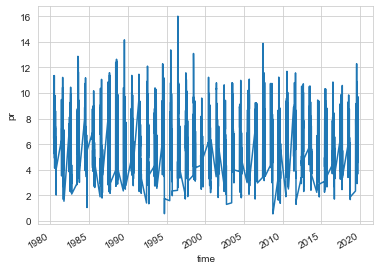

In [6]:
# Plot the average JJAS rainfal
# Are hear any problems
ds[var_name].mean(dim='lon').mean('lat').plot()

Compute next the day of year anomalies. Do you think we have to detrend the data?

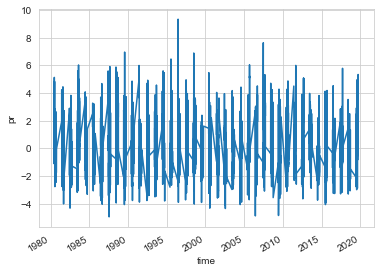

In [10]:
# Compute anomaly time series 
# Group each time point by its corresponding day of the year
group = 'dayofyear'
climatology = (
            ds[var_name].groupby(f"time.{group}").mean(dim="time")
        )
# Compute the anomalies
anomalies = ds[var_name].groupby(f"time.{group}") - climatology
anomalies.mean(dim='lon').mean('lat').plot()
ds['anomalies'] = anomalies


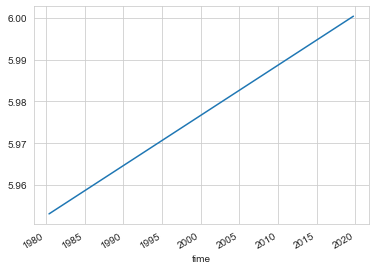

In [9]:
# Compute the fit coefficients
p = ds[var_name].polyfit(dim='time', deg=1)
# Apply the fit
fit = xr.polyval(ds['time'], p.polyfit_coefficients)
# The fit gives us the linear increase in each cell
da_detrend = ds[var_name] - fit  # Substract the linear increase from the actual data
fit.mean(dim='lon').mean('lat').plot()


We have seen the linear increase is very little.
Therefore, we do not need to detrend the data.  


## Now compute all pair-wise correlations

In [11]:
da = ds['anomalies']  # Use the anomaly data to compute the pairwise correlations
print('Dataset shape: ', da.shape)
dim_time, dim_lat, dim_lon = da.shape
# Bring all into a form of an array of time series
data = []
data = []
for idx, t in enumerate(da.time):
        buff = da.sel(time=t.data).data.flatten()  # flatten each time step
        buff[np.isnan(buff)] = 0.0  # set missing data to climatology
        data.append(buff)
data = np.array(data)
print('Flattend Dataset shape: ', data.shape)
corr, pvalue =  st.spearmanr(
        data, axis=0, nan_policy='propagate')
print('Shape of correlation Matrix: ', corr.shape)


Dataset shape:  (4880, 30, 30)
Flattend Dataset shape:  (4880, 900)
Shape of correlation Matrix:  (900, 900)


Not all correlations are statistically significant.
Let's first exclude non-significant correlations

In [12]:
confidence = 0.999
mask_confidence = np.where(pvalue <= (1 - confidence), 1, 0)  # p-value test
corr = np.where(mask_confidence==1, corr, 0)

In [13]:
# get minimum value that is still accounted as a correlation
# Do you think this is fine?
np.nanmin(np.where(np.abs(corr) != 0, np.abs(corr), np.nan))

0.04709030312116229

Now finally compute the adjacency matrix of the network

In [15]:
threshold = 0.3  # absolute threshold for correlations
mask_correlation = np.where(np.abs(corr) >= threshold, 1, 0)

# A link in the adjacency is placed for all significant values above the threshold
adjacency = mask_confidence * mask_correlation

# Obtain sparsity of adjacency matrix.
sparsity = (
    np.count_nonzero(adjacency.flatten()) / adjacency.shape[0]**2
)
print("Sparsity of adjacency: ", sparsity)

Sparsity of adjacency:  0.06961234567901235


Now that we have the adjacency, we create an networkx object based on the adjacency.  
Networkx provides powerful functions to further analyse the graph's topology.

In [16]:
# Use networkx for better using dealing with the adjacency matrix
import networkx as nx
cnx = nx.DiGraph(adjacency)

# Set the longitude and latitude as node attributes
lons = ds.lon
lats = ds.lat
lon_mesh, lat_mesh = np.meshgrid(lons, lats)  # This gives us a list of longitudes and latitudes per node
nx.set_node_attributes(cnx, {node: lon_mesh.flatten()[node] for node in cnx.nodes()}, 'lon')
nx.set_node_attributes(cnx, {node: lat_mesh.flatten()[node] for node in cnx.nodes()}, 'lat')


Now we make first steps to analyze the network.   
For example try the node degree of a node $i$ of the network is computed using the Adjacency matrix $A$:  
$$ k_i = \sum_i A_{ij} $$ 
or the Betweenness Centrality 
$$
BC_v(v_i) = \sum_{s,t}^N \frac{\sigma(v_s, v_t|v_i)}{\sigma(v_s, v_t)} \; ,  
$$
where $\sigma (v_s,v_t)$ denotes the number of shortest paths between nodes $v_s$ and $v_t$ and $\sigma(v_s,v_t | v_i) \leq \sigma(v_s,v_t)$ the number of all shortest paths that include node $v_i$. 
You can also try out other network measure.  

Compare your results with [Stolbova et al., 2014](https://npg.copernicus.org/articles/21/901/2014/). Do you find similarities/differences?  
Note, that current literature uses for precipitation analysis often another similarity measure than Spearman's correlation!

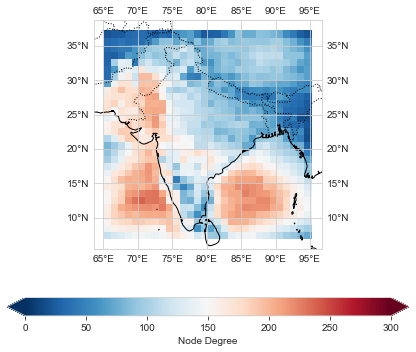

In [19]:
# Compute the node degree and plot it
reload(put)
degrees = np.array(cnx.degree())[:,1] # This returns the list of degrees
# Plot degrees
degree_arr = np.array(cnx.degree())[:,1].reshape(dim_lat, dim_lon)
degree_map = put.create_map_for_da(da=ds[var_name], data=degree_arr, name='degree')
im = put.plot_map(degree_map, 
                  label='Node Degree', 
                  vmin=0,
                  vmax=300)

In [28]:
# Compute the Betweenness centrality and plot it
reload(put)
btn = nx.betweenness_centrality(cnx) 


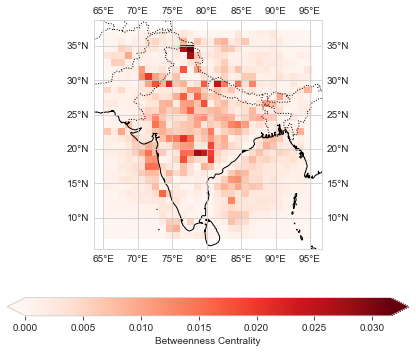

In [37]:
# Plot BC
bc_arr = np.array(list(btn.values())).reshape(dim_lat, dim_lon)
bc_map = put.create_map_for_da(da=ds[var_name], 
                               data=bc_arr, 
                               name='BC')
im = put.plot_map(bc_map, 
                  label='Betweenness Centrality', 
                  vmin=None,
                  cmap='Reds',
                  vmax=None)

### Visualize single edges of the network
To better analyze single parts of the network we want to extract the links from multiple specific regions.
Do you spot any particular differences to the global 2m-air temperature networks?  
As an example try different locations at the coast, at mountain areas, at high/low latitudes etc.

In [41]:
# Find out the nodes of the source region
lat_range = [20, 25]
lon_range = [75,78]
# Why is this masked needed?
mask = (
        (degree_map['lat'] >= min(lat_range))
        & (degree_map['lat'] <= max(lat_range))
        & (degree_map['lon'] >= min(lon_range))
        & (degree_map['lon'] <= max(lon_range))
        )
source_map = xr.where(mask, 1, np.nan)
# source_map.plot()

# Get Ids of locations
source_ids = np.where(source_map.data.flatten()==1)[0]  # flatten data and get position in array

# Find target Ids in the network
edge_list = []
for sid in source_ids:
        edge_list.append(list(cnx.edges(sid)))

edge_list = np.concatenate(edge_list, axis=0)  # transform to 2d np array

{'ax': <GeoAxesSubplot:>, 'projection': 'EqualEarth'}

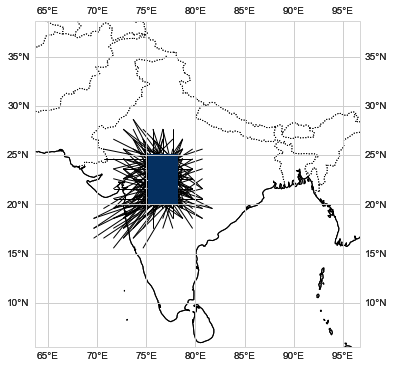

In [43]:
reload(put)
im = put.plot_map(source_map, bar=False, central_longitude=60)
put.plot_edges(cnx=cnx, edges=edge_list[::3], ax=im['ax'])  # Plot every 10th 


## Community detection in climate Networks
Now we want to see what is the overall structure of the network.  
Therefore we want to identify communities in the network. There are many algorithms to detect communities in graphs.  
Here, we use the standard [Louvain algorithm](https://en.wikipedia.org/wiki/Louvain_method) from the [NetworKit](https://networkit.github.io/dev-docs/notebooks/Community.html) package.  
It basically optimizes local density of edges to cluster a given graph into communities. 

In [44]:
# nk algorithm needs the nx network to be transformed as a nk object
cnk = nk.nxadapter.nx2nk(cnx.to_undirected())
# Use the Parallel Louvain Method (PLM) of NetworkIt
nkCommunities = nk.community.detectCommunities(
            cnk, algo=nk.community.PLM(cnk, True)
        )
CommunityIds = np.array(nkCommunities.getVector())

Communities detected in 0.00240 [s]
solution properties:
-------------------  ----------
# communities          5
min community size   120
max community size   231
avg. community size  180
modularity             0.659971
-------------------  ----------


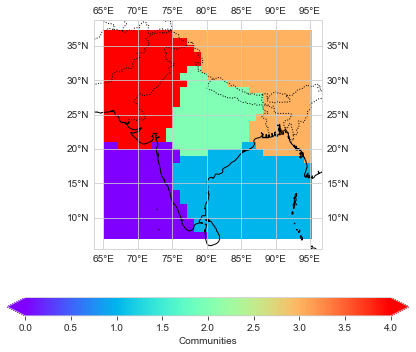

In [45]:

community_map = put.create_map_for_da(da=ds[var_name], data=CommunityIds.reshape(dim_lat, dim_lon), name='Communities')
im = put.plot_map(community_map, bar=True, 
                  cmap='rainbow',
                  central_longitude=0)

Can you explain the different communities? Try to compare the communities with different orographic zones and connect this then back to overall climate.

## Clustering of climate data
Compute the clusters of based on complete linkage clustering of the Spearman's Correlation Matrix!  
We follow the method from [Rheinwalt et al. 2015](https://link.springer.com/chapter/10.1007/978-3-319-17220-0_3), moreover our results can be compared to [Malik et al., 2010]( www.nonlin-processes-geophys.net/17/371/2010/) . 

In [46]:
def get_distance(corr, pvalue, confidence=0.999, threshold=None):
    """Get correlation and distance threshold for a given confidence level.

    Note: only positive correlations are considered here

    Return:
    -----
    threshold: float
        Threshold where the clustering is stopped
    distance: np.ndarray (n, n)
        Distance matrix
    corr_pos: np.ndarray (n, n)
        Correlation matrix with only positive correlations
    """
    # get only absolute correlations
    corr_pos = np.abs(corr)

    # get distance matrix
    distance = np.arccos(corr_pos)

    # consider only correlations with corresponding pvalues smaller than (1-confidence)
    mask_confidence = np.where(pvalue <= (
        1 - confidence), 1, 0)  # p-value test
    corr_pos = np.where(mask_confidence == 1, corr_pos, np.nan)

    # get threshold
    if threshold is None:
        idx_min = np.unravel_index(
                np.nanargmin(corr_pos.data), np.shape(corr_pos.data)
            )
    else:
        mask_corr = np.where(corr_pos >= threshold, 
                             corr_pos, np.nan)
        idx_min = np.unravel_index(
                np.nanargmin(mask_corr.data), np.shape(corr_pos.data)
            )
    threshold_corr = corr_pos[idx_min]
    threshold_dist = distance[idx_min]
    
    print(f"p-value {pvalue[idx_min]}, \n",
          f"correlation {threshold_corr} \n",
          f"Min distance threshold {threshold_dist}")

    return distance, threshold_dist

def complete_linkage_cluster(distance, threshold=None, linkage="complete", n_clusters=None):
        """Complete linkage clustering.
        Return:
        -------
        labels: list (n)
            Cluster label of each datapoint
        model: sklearn.cluster.AgglomerativeClustering
            Complete linkage clustering model
        """
        # Use Scipy Agglomerative Clustering for distances clustering!
        from sklearn.cluster import AgglomerativeClustering
        if n_clusters is not None:
            # Exactly one of n_clusters and distance_threshold has to be set,
            # and the other needs to be None. Here we set n_clusters if given!
            threshold = None
        
        # create hierarchical cluster
        model = AgglomerativeClustering(
            distance_threshold=threshold, 
            n_clusters=n_clusters, 
            compute_full_tree=True,
            affinity='precomputed', 
            connectivity=None, 
            linkage=linkage
        )
        labels = model.fit_predict(distance)
        print(
            f"Found {np.max(labels)+1} clusters for the given threshold {threshold}.")
        return labels, model


In [47]:
da = ds['anomalies']  # Use the anomaly data to compute the pairwise correlations
print('Dataset shape: ', da.shape)
dim_time, dim_lat, dim_lon = da.shape
# Bring all into a form of an array of time series
data = []
data = []
for idx, t in enumerate(da.time):
        buff = da.sel(time=t.data).data.flatten()  # flatten each time step
        buff[np.isnan(buff)] = 0.0  # set missing data to climatology
        data.append(buff)
data = np.array(data)
print('Flattend Dataset shape: ', data.shape)
corr, pvalue =  st.spearmanr(
        data, axis=0, nan_policy='propagate')
print('Shape of correlation Matrix: ', corr.shape)


Dataset shape:  (4880, 30, 30)
Flattend Dataset shape:  (4880, 900)
Shape of correlation Matrix:  (900, 900)


In [50]:
distance, threshold_dist = get_distance(corr=corr, pvalue=pvalue, threshold=0.2)
clusterIds, model = complete_linkage_cluster(distance=distance, 
                                             threshold=threshold_dist,
                                             n_clusters=5)

p-value 3.2626160809792945e-45, 
 correlation 0.20000141617821077 
 Min distance threshold 1.3694369606235188
Found 5 clusters for the given threshold None.


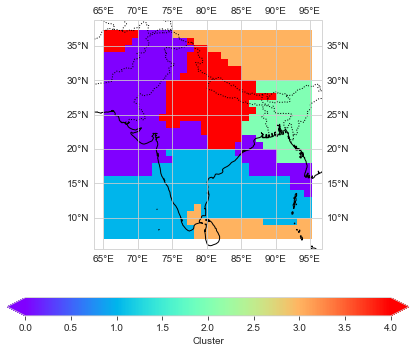

In [51]:
cluster_map = put.create_map_for_da(da=ds[var_name], data=clusterIds.reshape(dim_lat, dim_lon), name='Cluster')
im = put.plot_map(cluster_map, bar=True, 
                  cmap='rainbow',
                  central_longitude=0)